## Deep Q-Network (DQN) on `highway-fast-v0`

**Goal: **Train an autonomous-driving agent from scratch using the classic
DQN algorithm (Mnih et al., 2015) on the lightweight `highway-fast-v0`
environment from `highway-env`.
**Pipeline**
1. Environment & config
2. Model and replay buffer
3. Training loop with target network and ε-greedy exploration
4. Learning curves & evaluation run
---
*Authors* · Gabriel Souza Lima · Guilherme Mertens · Kiyoshi Araki · Lucas Tramonte

## 1. Imports

In [15]:
import gymnasium as gym
import highway_env
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import time

###  2. Load configuration and prepare environment

In [16]:
# We keep rendering="human" for immediate visual feedback

with open("config.pkl", "rb") as f:
    config = pickle.load(f)

env = gym.make("highway-fast-v0", render_mode="human")
env.unwrapped.configure(config)
obs_sample, _ = env.reset()
obs_shape = obs_sample.shape
n_actions = env.action_space.n

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3. Define Hyperparameters

In [17]:
# Tweakable knobs.  Most are textbook defaults except:
# TARGET_UPDATE = 5  → faster sync because the env is very stochastic
# LR is bumped down to 1e-4 for stability with fully-connected network.

GAMMA = 0.99             # Discount factor
EPS_START = 1.0          # Initial epsilon for exploration
EPS_END = 0.05           # Final epsilon
EPS_DECAY = 500          # Epsilon decay rate
LR = 1e-3                # Learning rate
BATCH_SIZE = 64
TARGET_UPDATE = 5  # updated for more frequent sync       # Target network update interval
MEMORY_SIZE = 100_000
NUM_EPISODES = 150
MAX_STEPS = 400 # env terminates earlier if crash/goal

### 4. Q-Network Architecture

In [18]:
# For `highway-fast` the observation is already a compact 5×5 tensor
# (rows = nearby vehicles, cols = features). 

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super().__init__()
        flat_dim = int(np.prod(input_shape))     # 25 features
        self.fc = nn.Sequential(
            nn.Linear(flat_dim, 256), nn.ReLU(),
            nn.Linear(256, 256),       nn.ReLU(),
            nn.Linear(256, n_actions)           # Q-value per discrete action
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)               # flatten batch
        return self.fc(x)

### 5. Replay Buffer

In [19]:
# A fixed-size circular buffer that supplies i.i.d. mini-batches.
# De-correlates consecutive samples and stabilises learning.

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

### 6. Epsilon-Greedy Action Selection


In [20]:
# Epsilon decays exponentially with the *global* step counter
#   ε_t = ε_end + (ε_start-ε_end) · exp(−t / decay)

def select_action(state, steps_done, policy_net):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-steps_done / EPS_DECAY)
    if random.random() < eps_threshold:            # explore
        return random.randrange(n_actions)
    with torch.no_grad():                          # exploit
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        return policy_net(state).argmax().item()

### 7. Training Loop

In [21]:
# Main RL routine:
# Environment interaction ➜ push transition into replay buffer
# Once enough samples ➜ update policy_net
# Every TARGET_UPDATE episodes ➜ hard-copy weights into target_net

device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net   = DQN(obs_shape, n_actions).to(device)
target_net   = DQN(obs_shape, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()                                   # inference-only

optimizer     = optim.Adam(policy_net.parameters(), lr=LR)
replay_buffer = ReplayBuffer(MEMORY_SIZE)

returns, losses = [], []
steps_done      = 0

for episode in range(NUM_EPISODES):
    state, _ = env.reset()
    total_reward = 0

    for t in range(MAX_STEPS):
        action = select_action(state, steps_done, policy_net)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        steps_done  += 1

        # --- Gradient step ---------------------------------------------------
        if len(replay_buffer) > BATCH_SIZE:
            S, A, R, S2, D = replay_buffer.sample(BATCH_SIZE)
            S   = torch.tensor(S,  dtype=torch.float32, device=device)
            A   = torch.tensor(A,  dtype=torch.int64,  device=device).unsqueeze(1)
            R   = torch.tensor(R,  dtype=torch.float32, device=device).unsqueeze(1)
            S2  = torch.tensor(S2, dtype=torch.float32, device=device)
            D   = torch.tensor(D,  dtype=torch.float32, device=device).unsqueeze(1)

            q_sa      = policy_net(S).gather(1, A)                 # Q(s,a)
            with torch.no_grad():
                q_s2_max = target_net(S2).max(1)[0].unsqueeze(1)   # max_a' Q̂(s',a')
                y = R + GAMMA * q_s2_max * (1 - D)                 # TD target

            loss = nn.MSELoss()(q_sa, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 10)
            optimizer.step()
            losses.append(loss.item())
        # ---------------------------------------------------------------------

        if done:
            break

    # sync target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    returns.append(total_reward)
    print(f"Episode {episode+1:3}/{NUM_EPISODES}, return={total_reward:7.2f}")

Episode   1/150, return=   6.07
Episode   2/150, return=  36.01
Episode   3/150, return=  10.79
Episode   4/150, return=   2.01
Episode   5/150, return=  11.83
Episode   6/150, return=   2.79
Episode   7/150, return=  19.54
Episode   8/150, return=   3.46
Episode   9/150, return=   5.08
Episode  10/150, return=  51.71
Episode  11/150, return=   2.07
Episode  12/150, return=   8.34
Episode  13/150, return=  49.60
Episode  14/150, return=   2.49
Episode  15/150, return=  18.55
Episode  16/150, return=  12.04
Episode  17/150, return=   7.52
Episode  18/150, return=   4.95
Episode  19/150, return=  12.58
Episode  20/150, return=  55.84
Episode  21/150, return=   6.13
Episode  22/150, return=   2.27
Episode  23/150, return=  54.18
Episode  24/150, return=   8.70
Episode  25/150, return=  41.20
Episode  26/150, return=  46.66
Episode  27/150, return=   4.25
Episode  28/150, return=  35.74
Episode  29/150, return=  15.37
Episode  30/150, return=  45.60
Episode  31/150, return=  38.31
Episode 

### 8. Visualize Performance

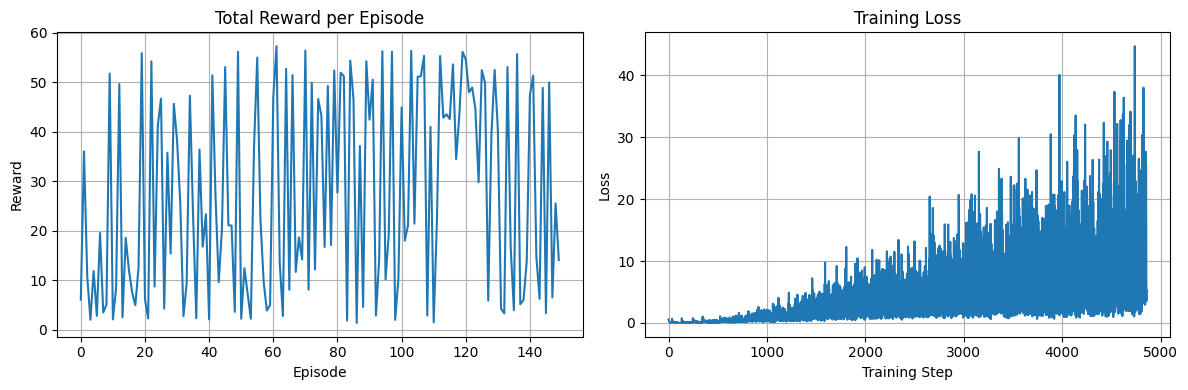

: 

In [22]:
# Helps diagnose: divergence, saturation, exploration-exploitation balance.

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(returns)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()

### 9. Evaluate the trained agent


In [ ]:
# We freeze ε=0, re-instantiate the env, and step the *learned* policy
# in real time (40 FPS) so you can watch lane changes and overtakes.

eval_env = gym.make("highway-fast-v0", render_mode="human")
eval_env.unwrapped.configure(config)

state, _ = eval_env.reset()

for _ in range(400):
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action = policy_net(state_tensor).argmax().item()
    state, reward, done, truncated, _ = eval_env.step(action)
    eval_env.render()
    time.sleep(0.05)
    if done or truncated:
        break

eval_env.close()

### 10. Save artefacts

In [ ]:
# Re-use with: `model.load_state_dict(torch.load("trained_dqn_agent.pth"))`

torch.save(policy_net.state_dict(), "trained_dqn_agent.pth")
print("✔️  Model saved as trained_dqn_agent.pth")

✅ Model saved as trained_dqn_agent.pth
